In [ ]:
# --- INSTALL DEPENDENCIES ---
!pip install transformers datasets scikit-learn wandb accelerate sentencepiece -q

In [ ]:
# Polarization Detection Shared Task - Subtask 1 (Arabic)
# Binary Classification: Polarized vs Non-Polarized
# Using UBC-NLP/marbert for Arabic text

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
set_seed(42)

# ============================================================================
# CONFIGURATION
# ============================================================================
MODEL_NAME = "UBC-NLP/marbert"  # Best performing Arabic BERT model
MAX_LENGTH = 256
BATCH_SIZE = 16
GRAD_ACCUMULATION = 1
LEARNING_RATE = 1e-5
EPOCHS = 8
WARMUP_RATIO = 0.1

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Language: Arabic")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")

# Check for GPU
if not torch.cuda.is_available():
    print("\nWARNING: Running on CPU. Switch to GPU for faster training.")
    print("Go to Runtime > Change runtime type > T4 GPU")
else:
    print(f"\nGPU Detected: {torch.cuda.get_device_name(0)}")

# ============================================================================
# LOAD DATA
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Path configuration - adjust this to your folder structure
DATA_PATH = "/content/drive/MyDrive/AIMS/NLP/dev_phase/subtask1"

try:
    train_df = pd.read_csv(f"{DATA_PATH}/train/arb.csv")
    test_df = pd.read_csv(f"{DATA_PATH}/dev/arb.csv")
    print(f"\nLoaded {len(train_df)} training rows from train/arb.csv")
    print(f"Loaded {len(test_df)} test rows from dev/arb.csv")
    print(f"Training columns: {train_df.columns.tolist()}")
except FileNotFoundError as e:
    raise ValueError(f"Could not find files in {DATA_PATH}. Please check the path.\nError: {e}")

Configuration:
  Model: UBC-NLP/marbert
  Language: Arabic
  Max Length: 256
  Batch Size: 16
  Learning Rate: 1e-05
  Epochs: 8

GPU Detected: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loaded 3380 training rows from train/arb.csv
Loaded 169 test rows from dev/arb.csv
Training columns: ['id', 'text', 'polarization']



--- Data Preprocessing ---
Cleaned training data shape: (3380, 3)

Label Distribution:
  Non-Polarized (0): 1868 (55.27%)
  Polarized (1): 1512 (44.73%)

Cleaned test data shape: (169, 3)

--- Class Weights (Balanced) ---
  Non-Polarized (0): 0.81x
  Polarized (1): 1.24x

--- Data Split ---
Training samples: 2873
Validation samples: 507
Test samples: 169

Validation Label Distribution:
  Class 0: 280 (55.23%)
  Class 1: 227 (44.77%)

Loading marBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Datasets created:
  Train dataset size: 2873
  Validation dataset size: 507

Loading marBERT model...


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/marbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully

STARTING TRAINING (ARABIC)



Epoch,Training Loss,Validation Loss,F1 Macro
1,0.452800,0.415882,0.796461
2,0.347900,0.474697,0.811872
3,0.272100,0.504426,0.808533
4,0.168600,0.758756,0.799135
5,0.121200,0.991777,0.786348



Training completed successfully



--- Validation Results (0.5 threshold) ---
Macro F1: 0.8119

THRESHOLD OPTIMIZATION

Best Threshold: 0.420
Optimized Macro F1: 0.8272


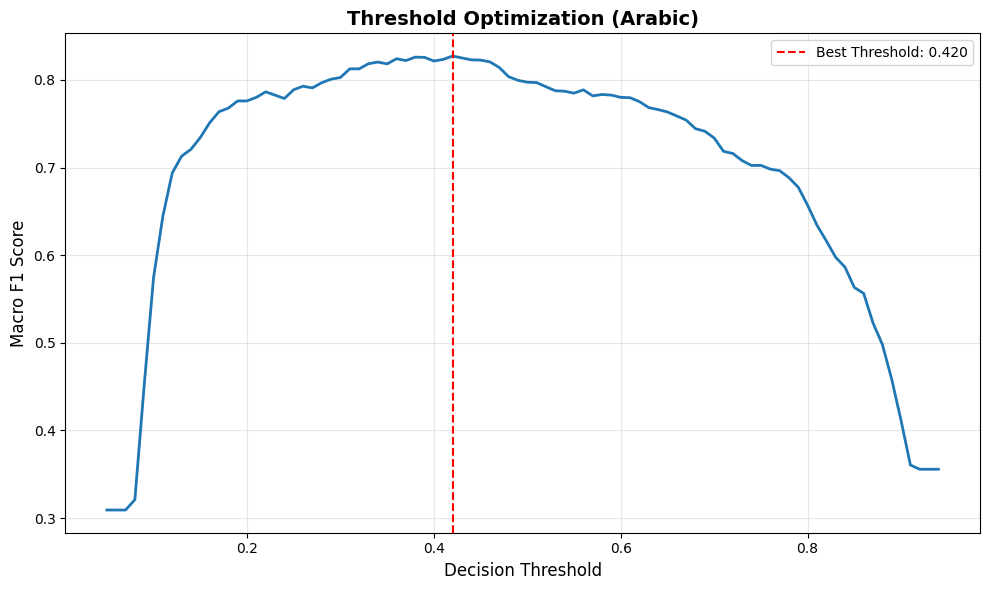


VALIDATION SET PERFORMANCE


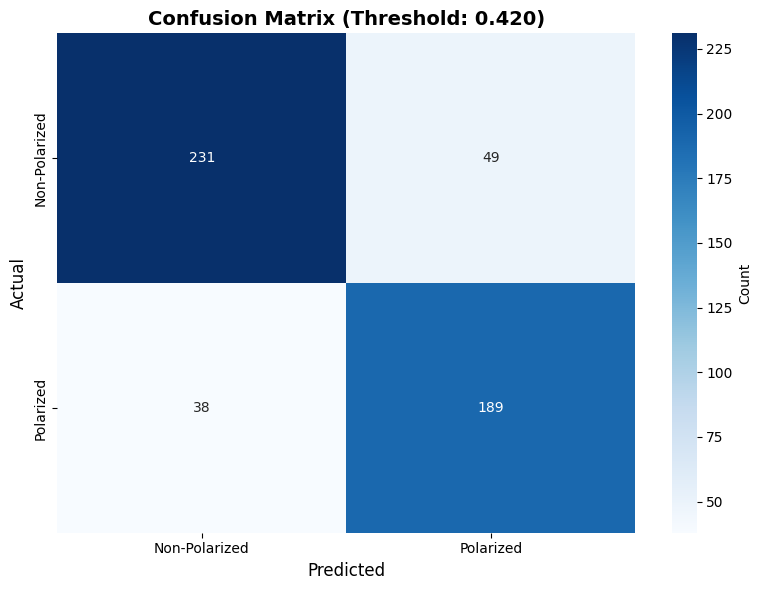


Detailed Classification Report:
               precision    recall  f1-score   support

Non-Polarized     0.8587    0.8250    0.8415       280
    Polarized     0.7941    0.8326    0.8129       227

     accuracy                         0.8284       507
    macro avg     0.8264    0.8288    0.8272       507
 weighted avg     0.8298    0.8284    0.8287       507


Per-Class Metrics:
  Non-Polarized Precision: 0.8587
  Non-Polarized Recall:    0.8250
  Non-Polarized F1:        0.8415
  Polarized Precision:     0.7941
  Polarized Recall:        0.8326
  Polarized F1:            0.8129
  Macro F1:                0.8272

GENERATING TEST SET PREDICTIONS



Test predictions generated for 169 samples

Prediction Distribution:
  Non-Polarized (0): 103 (60.95%)
  Polarized (1): 66 (39.05%)

Sample Predictions (first 10 rows):
                                  id  polarization                                           text_preview
arb_67be47e5216d7bee41e17484e619f4e6             1  حيل بيج يانذله تحجين ع العراقيات بس احنه العراقيات...
arb_272322e5b265e177613d685e5619e402             0 على زبي\nيا ليتها تجي معي البر اخليها تسوق دباب ما ...
arb_d1ec38dd0ec5d7a4fe28ef8317fc96c1             0  كل المغنين ولي يدخلون  المسيقه  في  أغانيهم  نكرا ...
arb_fad75310b17c124d98ebc514189ec033             1  الله يخلق ونحنا نبتلي بكل ما تعنيه الكلامات من معن...
arb_95caf70cec5bf00c94c35cf7af2a0ab5             1         رئيس الدولة كافر والشعب ساكت خاطرو شعب طحان...
arb_ac108c1ecf5071892c61abd253847b15             1  سبحان الله تاركين مريام وهيفاء ومروى الي يطلعون شب...
arb_adaaa6d482119e65ce337ee224674e70             1  لازم يسحبوا منها الجنسيه الاماراتيه 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submission file downloaded to your computer

PROCESS COMPLETE

Your Arabic submission file is ready for competition upload!
Final validation Macro F1: 0.8272
Optimized threshold: 0.420


In [ ]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
print("\n--- Data Preprocessing ---")

# Clean training data
train_df['text'] = train_df['text'].fillna('').astype(str)
train_df['text'] = train_df['text'].str.strip()
train_df['polarization'] = train_df['polarization'].fillna(0).astype(int)

# Remove empty texts
train_df = train_df[train_df['text'].str.len() > 0].reset_index(drop=True)

# Ensure only valid labels (0 or 1)
train_df = train_df[train_df['polarization'].isin([0, 1])].reset_index(drop=True)

print(f"Cleaned training data shape: {train_df.shape}")
print(f"\nLabel Distribution:")
label_counts = train_df['polarization'].value_counts()
print(f"  Non-Polarized (0): {label_counts[0]} ({label_counts[0]/len(train_df)*100:.2f}%)")
print(f"  Polarized (1): {label_counts[1]} ({label_counts[1]/len(train_df)*100:.2f}%)")

# Clean test data
test_df['text'] = test_df['text'].fillna('').astype(str)
test_df['text'] = test_df['text'].str.strip()
test_df = test_df[test_df['text'].str.len() > 0].reset_index(drop=True)

print(f"\nCleaned test data shape: {test_df.shape}")

# ============================================================================
# CALCULATE CLASS WEIGHTS
# ============================================================================
total_samples = len(train_df)
pos_count = (train_df['polarization'] == 1).sum()
neg_count = (train_df['polarization'] == 0).sum()

# Inverse frequency weights with smoothing
alpha = 0.5
weight_neg = (pos_count + alpha) / (neg_count + alpha)
weight_pos = (neg_count + alpha) / (pos_count + alpha)

class_weights = torch.tensor([weight_neg, weight_pos], dtype=torch.float)

print("\n--- Class Weights (Balanced) ---")
print(f"  Non-Polarized (0): {weight_neg:.2f}x")
print(f"  Polarized (1): {weight_pos:.2f}x")

# ============================================================================
# TRAIN-VALIDATION SPLIT
# ============================================================================
train_texts = train_df['text'].values
train_labels = train_df['polarization'].values

# Stratified 85-15 split
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts,
    train_labels,
    test_size=0.15,
    random_state=42,
    stratify=train_labels
)

print(f"\n--- Data Split ---")
print(f"Training samples: {len(train_texts_split)}")
print(f"Validation samples: {len(val_texts_split)}")
print(f"Test samples: {len(test_df)}")

print(f"\nValidation Label Distribution:")
val_unique, val_counts = np.unique(val_labels_split, return_counts=True)
for label, count in zip(val_unique, val_counts):
    print(f"  Class {label}: {count} ({count/len(val_labels_split)*100:.2f}%)")

# ============================================================================
# DATASET CLASS
# ============================================================================
class PolarizationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, is_test=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Note: For Arabic text, no lowercase transformation is applied
        # as it would break the script

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
            add_special_tokens=True
        )

        item = {k: v.squeeze() for k, v in inputs.items()}

        if not self.is_test:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# Create tokenizer and datasets
print("\nLoading marBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = PolarizationDataset(train_texts_split, train_labels_split, tokenizer, MAX_LENGTH)
val_dataset = PolarizationDataset(val_texts_split, val_labels_split, tokenizer, MAX_LENGTH)

print(f"\nDatasets created:")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")

# ============================================================================
# WEIGHTED TRAINER
# ============================================================================
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels)
        else:
            loss = outputs.loss

        return (loss, outputs) if return_outputs else loss

# ============================================================================
# METRICS COMPUTATION
# ============================================================================
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return {'f1_macro': macro_f1}

# ============================================================================
# MODEL INITIALIZATION
# ============================================================================
print("\nLoading marBERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

print("Model loaded successfully")

# ============================================================================
# TRAINING ARGUMENTS
# ============================================================================
training_args = TrainingArguments(
    output_dir="./results_subtask1_arabic",
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=GRAD_ACCUMULATION,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    fp16=True,
    weight_decay=0.01,
    warmup_ratio=WARMUP_RATIO,
    report_to="none",
    save_total_limit=1,
    gradient_checkpointing=False,
    dataloader_num_workers=2,
    lr_scheduler_type="cosine",
    seed=42
)

# ============================================================================
# TRAIN MODEL
# ============================================================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("\n" + "="*70)
print("STARTING TRAINING (ARABIC)")
print("="*70 + "\n")

trainer.train()

print("\nTraining completed successfully")

# ============================================================================
# VALIDATION EVALUATION (0.5 threshold)
# ============================================================================
eval_stats = trainer.evaluate()
print(f"\n--- Validation Results (0.5 threshold) ---")
print(f"Macro F1: {eval_stats['eval_f1_macro']:.4f}")

# ============================================================================
# THRESHOLD OPTIMIZATION
# ============================================================================
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

raw_preds = trainer.predict(val_dataset)
logits = raw_preds.predictions
probs = expit(logits)  # Convert logits to probabilities using sigmoid
y_true = raw_preds.label_ids

# Get probability of class 1 (Polarized)
positive_probs = probs[:, 1]

# Grid search for best threshold
thresholds = np.arange(0.05, 0.95, 0.01)
best_f1 = 0
best_thresh = 0.5

threshold_results = []
for t in thresholds:
    preds = (positive_probs >= t).astype(int)
    current_f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    threshold_results.append({'threshold': t, 'f1_macro': current_f1})
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = t

print(f"\nBest Threshold: {best_thresh:.3f}")
print(f"Optimized Macro F1: {best_f1:.4f}")

# Plot threshold vs F1 score
threshold_df = pd.DataFrame(threshold_results)
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['f1_macro'], linewidth=2)
plt.axvline(x=best_thresh, color='r', linestyle='--', label=f'Best Threshold: {best_thresh:.3f}')
plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Macro F1 Score', fontsize=12)
plt.title('Threshold Optimization (Arabic)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply optimized threshold
final_preds = (positive_probs >= best_thresh).astype(int)

# ============================================================================
# DETAILED VALIDATION ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

# Confusion Matrix
cm = confusion_matrix(y_true, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Polarized', 'Polarized'],
            yticklabels=['Non-Polarized', 'Polarized'],
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title(f'Confusion Matrix (Threshold: {best_thresh:.3f})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, final_preds,
                          target_names=['Non-Polarized', 'Polarized'],
                          digits=4,
                          zero_division=0))

# Per-class metrics
from sklearn.metrics import precision_score, recall_score
print("\nPer-Class Metrics:")
print(f"  Non-Polarized Precision: {precision_score(y_true, final_preds, pos_label=0, zero_division=0):.4f}")
print(f"  Non-Polarized Recall:    {recall_score(y_true, final_preds, pos_label=0, zero_division=0):.4f}")
print(f"  Non-Polarized F1:        {f1_score(y_true, final_preds, pos_label=0, zero_division=0):.4f}")
print(f"  Polarized Precision:     {precision_score(y_true, final_preds, pos_label=1, zero_division=0):.4f}")
print(f"  Polarized Recall:        {recall_score(y_true, final_preds, pos_label=1, zero_division=0):.4f}")
print(f"  Polarized F1:            {f1_score(y_true, final_preds, pos_label=1, zero_division=0):.4f}")
print(f"  Macro F1:                {best_f1:.4f}")

# ============================================================================
# TEST SET PREDICTIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING TEST SET PREDICTIONS")
print("="*70)

# Create test dataset
test_texts = test_df['text'].values
test_labels_dummy = np.zeros(len(test_texts))  # Dummy labels for test set
test_dataset = PolarizationDataset(test_texts, test_labels_dummy, tokenizer, MAX_LENGTH, is_test=True)

# Get predictions
test_raw_preds = trainer.predict(test_dataset)
test_logits = test_raw_preds.predictions
test_probs = expit(test_logits)
test_positive_probs = test_probs[:, 1]

# Apply optimized threshold
test_predictions = (test_positive_probs >= best_thresh).astype(int)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'polarization': test_predictions
})

print(f"\nTest predictions generated for {len(submission)} samples")
print(f"\nPrediction Distribution:")
pred_counts = submission['polarization'].value_counts()
print(f"  Non-Polarized (0): {pred_counts[0]} ({pred_counts[0]/len(submission)*100:.2f}%)")
print(f"  Polarized (1): {pred_counts[1]} ({pred_counts[1]/len(submission)*100:.2f}%)")

# Display sample predictions
print("\nSample Predictions (first 10 rows):")
sample_display = submission.head(10).copy()
sample_display['text_preview'] = test_df['text'].head(10).str[:50] + '...'
print(sample_display.to_string(index=False))

# Save submission file
submission_path = 'subtask1_arabic_submission.csv'
submission.to_csv(submission_path, index=False)
print(f"\nSubmission file saved: {submission_path}")

# Download file
try:
    from google.colab import files
    files.download(submission_path)
    print("Submission file downloaded to your computer")
except:
    print("File saved but could not auto-download. Please download manually from files panel.")

print("\n" + "="*70)
print("PROCESS COMPLETE")
print("="*70)
print("\nYour Arabic submission file is ready for competition upload!")
print(f"Final validation Macro F1: {best_f1:.4f}")
print(f"Optimized threshold: {best_thresh:.3f}")